# Flower Image Classifier

In this project, an image classifier is trained to recognize different species of flowers. I used [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on the dataset
* Use the trained classifier to predict image content

In [2]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt 
from collections import OrderedDict
from PIL import Image
import numpy as np
import seaborn as sb

## Load the data

Here I used `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The dataset is split into three parts, training, validation, and testing. For the training, I applied transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. The input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this I didn't use any scaling or rotation transformations, but I resized then cropped the images to the appropriate size.

The pre-trained network I used was trained on the ImageNet dataset where each color channel was normalized separately. For all three sets I normalized the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [4]:
# Define transforms for the training, validation, and testing sets
data_transforms = {'train': transforms.Compose([transforms.RandomRotation(30),
                                               transforms.RandomResizedCrop(224),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406],
                                                                    [0.229, 0.224, 0.225])]),
                  'valid': transforms.Compose([transforms.Resize(255),
                                              transforms.CenterCrop(224),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406],
                                                                    [0.229, 0.224, 0.225])]),
                  'test': transforms.Compose([transforms.Resize(255),
                                              transforms.CenterCrop(224),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406],
                                                                    [0.229, 0.224, 0.225])])}

# Load the datasets with ImageFolder
image_datasets = {'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
                 'valid': datasets.ImageFolder(valid_dir, transform=data_transforms['valid']),
                 'test': datasets.ImageFolder(test_dir, transform=data_transforms['test'])}

# Using the image datasets and the trainforms, define the dataloaders
dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=64, shuffle=True),
              'valid': torch.utils.data.DataLoader(image_datasets['valid'], batch_size=64, shuffle=True),
              'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=64, shuffle=True)}

### Label mapping

I loaded in a mapping from category label to category name. The file is named as `cat_to_name.json`. It's a JSON object which can be read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. I used the `densenet121` pretrained model from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

Next I did the following steps:

* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

I trained the model for 10 `epochs` and was able to reach an accuracy of `0.901` on the validation set.

In [5]:
# Loading the model
model = models.densenet121(pretrained=True)

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:00<00:00, 95416543.93it/s]


In [6]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [7]:
# Freezing the parameters

for param in model.parameters():
    param.requires_grad=False

In [8]:
# Defining a new classifier for the model

classifier = nn.Sequential(nn.Linear(1024, 512),
                           nn.ReLU(),
                           nn.Dropout(0.2),
                           nn.Linear(512,102),
                           nn.LogSoftmax(dim=1))

# Replacing the existing classifier with new one                                        
model.classifier = classifier

In [9]:
# Defining criterion
criterion = nn.NLLLoss()

# Defining optimizer only for the classifier part
optimizer = optim.Adam(model.classifier.parameters(), lr= 0.003)

In [24]:
# For continuing training loading the optimizer state
checkpoint = torch.load('checkpoint_densenet121.pth', map_location='cpu')
optimizer.load_state_dict(checkpoint['optimizer_state'])

In [25]:
# Use GPU if available else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = 5
steps = 0
running_trainloss = 0
print_every = 10

In [26]:
# Moving model to available device
model.to(device)
model.train()
# Start of training process
for epoch in range(epochs):
    for images, labels in dataloaders['train']:
        steps +=1 
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        logps = model.forward(images)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_trainloss+=loss.item()
        
        if steps % print_every == 0:
            model.eval()
            accuracy = 0
            running_validloss = 0
            with torch.no_grad():
                for images, labels in dataloaders['valid']:
                    images, labels = images.to(device), labels.to(device)
                    logps = model.forward(images)
                    loss = criterion(logps, labels)
                    running_validloss += loss.item()
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equal = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equal.type(torch.FloatTensor)).item()
            
            print(f"Epochs: {epoch+1}/{epochs}..."
                  f"Current trainloss: {running_trainloss/print_every:.3f}..."
                  f"Current testloss: {running_validloss/len(dataloaders['valid']):.3f}..."
                  f"Current accuracy: {accuracy/len(dataloaders['valid']):.3f}")
            
            running_trainloss =0
            model.train()

Epochs: 1/5...Current trainloss: 0.667...Current testloss: 0.391...Current accuracy: 0.897
Epochs: 1/5...Current trainloss: 0.625...Current testloss: 0.389...Current accuracy: 0.899
Epochs: 1/5...Current trainloss: 0.687...Current testloss: 0.392...Current accuracy: 0.895
Epochs: 1/5...Current trainloss: 0.661...Current testloss: 0.393...Current accuracy: 0.893
Epochs: 1/5...Current trainloss: 0.707...Current testloss: 0.393...Current accuracy: 0.895
Epochs: 1/5...Current trainloss: 0.586...Current testloss: 0.390...Current accuracy: 0.895
Epochs: 1/5...Current trainloss: 0.639...Current testloss: 0.391...Current accuracy: 0.896
Epochs: 1/5...Current trainloss: 0.593...Current testloss: 0.386...Current accuracy: 0.896
Epochs: 1/5...Current trainloss: 0.615...Current testloss: 0.378...Current accuracy: 0.897
Epochs: 1/5...Current trainloss: 0.653...Current testloss: 0.386...Current accuracy: 0.895
Epochs: 2/5...Current trainloss: 0.677...Current testloss: 0.394...Current accuracy: 0.896

## Testing your network
On making predictions on the test set the model was able to reach an accuracy of `0.886`.

In [27]:
# Validation on the test set
model.eval()
accuracy = 0
testloss = 0
with torch.no_grad():
    for images, labels in dataloaders['test']:
        images, labels = images.to(device), labels.to(device)
        logps = model.forward(images)
        loss = criterion(logps, labels)
        testloss += loss.item()
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equal = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equal.type(torch.FloatTensor)).item()

print(f"Current testloss: {testloss/len(dataloaders['test']):.3f}..."
      f"Current accuracy: {accuracy/len(dataloaders['test']):.3f}")

Current testloss: 0.402...Current accuracy: 0.886


## Save the checkpoint

Now that the network is trained, I saved the model so I can load it later for making predictions. I saved other things such as the mapping of classes to indices which can be obtained from one of the image datasets: `image_datasets['train'].class_to_idx`. I attached this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

As I want to load the model and keep training, I saved the number of epochs as well as the optimizer state, `optimizer.state_dict`.

In [28]:
# Save the checkpoint
model.to('cpu')
checkpoint = {'model': 'densenet121',
             'epochs': 10,
             'input_size': 1024,
             'output_size': 102,
             'hidden_layer': [512],
             'class_to_idx': image_datasets['train'].class_to_idx,
             'state_dict': model.state_dict(),
             'optimizer_state': optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint_densenet121.pth')

## Loading the checkpoint

I wrote a function that can load a checkpoint and rebuild the model.

In [6]:
# Function that loads a checkpoint and rebuilds the model
def load_checkpoint(path):
    checkpoint = torch.load(path, map_location='cpu')
    model = models.densenet121(pretrained=True)
    model.class_to_idx = checkpoint['class_to_idx']
    
    for params in model.parameters():
        params.requires_grad = False
        
    model.classifier = nn.Sequential(nn.Linear(checkpoint['input_size'], checkpoint['hidden_layer'][0]),
                                    nn.ReLU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(checkpoint['hidden_layer'][-1],checkpoint['output_size']),
                                    nn.LogSoftmax(dim=1))
    
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

# Inference for classification

Now I wrote a function to use the trained network for inference. I can pass an image into the network and predict the class of the flower in the image. The function is called `predict` that can take an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First I processed the input image such that it can be used in your network.
I used the same transformations that was used on the test and validation sets.

In [7]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a image for use in a PyTorch model
    img = Image.open(image)
    
    transform =transforms.Compose([transforms.Resize(256),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])])
    img_tensor = transform(img)
    img_numpy = img_tensor.numpy()
    return img_numpy

The function below recieves an image as Pytorch tensor and displays it in the notebook.

In [8]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    if title:
        ax.set_title(title)
    return ax

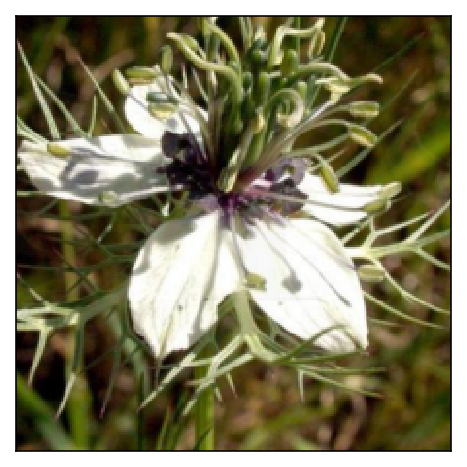

In [9]:
image_path = 'flowers/test/33/image_06456.jpg'
img = process_image(image_path)
imshow(img)

## Class Prediction

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. I converted these indices to the actual class labels using `class_to_idx` which was added to the model from an `ImageFolder` I used to load the data ([see here](#Save-the-checkpoint)). I also inverted the dictionary so I get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [10]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Predict the class from an image file
    img = torch.from_numpy(process_image(image_path))
    img.unsqueeze_(0)
    model.eval()
    with torch.no_grad():
        ps = torch.exp(model.forward(img))
    top_p, top_label = ps.topk(topk, dim=1)
    idx_to_class = {value : key for key, value in model.class_to_idx.items()}
    top_class = [idx_to_class[label] for label in top_label.numpy().reshape(topk)]
    return list(top_p.numpy().reshape(topk)), top_class

In [11]:
model = load_checkpoint('checkpoint_densenet121.pth')

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:00<00:00, 91340384.37it/s]


In [12]:
probs, classes = predict('flowers/test/33/image_06456.jpg', model)
print(probs)
print(classes)

[0.88222647, 0.024270274, 0.023252048, 0.012382473, 0.0074115652]
['33', '57', '38', '77', '30']


## Sanity Checking

I used `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

I converted the class integer encoding to actual flower names with the `cat_to_name.json` file. To show a PyTorch tensor as an image, I used the `imshow` function defined above.

In [ ]:
# Display an image along with the top 5 classes
fig, (ax1,ax2) = plt.subplots(figsize=(5, 10), nrows= 2)
image_path = 'flowers/test/70/image_05324.jpg'
img = process_image(image_path)
title = cat_to_name[image_path.split('/')[2]]
imshow(img, ax = ax1, title= title);

probs, classes = predict(image_path, model)

ticks = [cat_to_name[key] for key in classes]
sb.barplot(x=probs, y = ticks, ax = ax2, color=sb.color_palette()[0])
plt.show()